In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3/transformers/8b-chat-hf/1/model.safetensors.index.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00003-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf/1/config.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/LICENSE
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00001-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/USE_POLICY.md
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer_config.json
/kaggle/input/llama-3/transformers/8b-chat-hf/1/example_text_completion.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/test_tokenizer.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/requirements.txt
/kaggle/input/llama-3/transformers/8b-chat-hf/1/tokenizer.py
/kaggle/input/llama-3/transformers/8b-chat-hf/1/model-00004-of-00004.safetensors
/kaggle/input/llama-3/transformers/8b-chat-hf

# Installing and Upgrading Essential Libraries for Transformer Models and Efficient Fine-Tuning

In [2]:
%%capture
%pip install -U transformers 
%pip install -U datasets 
%pip install -U accelerate 
%pip install -U peft 
%pip install -U trl 
%pip install -U bitsandbytes 
%pip install -U wandb

# Installing ROUGE Score and Evaluation Libraries

In [3]:
%pip -q install rouge_score
%pip -q install evaluate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Defining Paths for Base Model and Fine-Tuned Model

In [4]:
base_model = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

new_model = "llama-3-8b-chat-doctor"

# Libraries and Packages

In [5]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, setup_chat_format

In [6]:
torch_dtype = torch.float16
attn_implementation = "eager"

# Loading Model and Tokenizer

In [7]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/llama-3/transformers/8b-chat-hf/1",
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
model, tokenizer = setup_chat_format(model, tokenizer)

# Configuring and Applying LoRA for Model Fine-Tuning

In [9]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

In [10]:
#Importing the dataset
dataset_name = "ruslanmv/ai-medical-chatbot"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=65).select(range(1000)) # Only use 1000 samples for quick demo

def format_chat_template(row):
    row_json = [{"role": "user", "content": row["Patient"]},
               {"role": "assistant", "content": row["Doctor"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc=4,
)

dataset['text'][3]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

'<|im_start|>user\nFell on sidewalk face first about 8 hrs ago. Swollen, cut lip bruised and cut knee, and hurt pride initially. Now have muscle and shoulder pain, stiff jaw(think this is from the really swollen lip),pain in wrist, and headache. I assume this is all normal but are there specific things I should look for or will I just be in pain for a while given the hard fall?<|im_end|>\n<|im_start|>assistant\nHello and welcome to HCM,The injuries caused on various body parts have to be managed.The cut and swollen lip has to be managed by sterile dressing.The body pains, pain on injured site and jaw pain should be managed by pain killer and muscle relaxant.I suggest you to consult your primary healthcare provider for clinical assessment.In case there is evidence of infection in any of the injured sites, a course of antibiotics may have to be started to control the infection.Thanks and take careDr Shailja P Wahal<|im_end|>\n'

# Splitting Dataset into Training and Testing Sets

In [11]:
dataset = dataset.train_test_split(test_size=0.1 , shuffle = False)

In [12]:
dataset['test']

Dataset({
    features: ['Description', 'Patient', 'Doctor', 'text'],
    num_rows: 100
})

In [13]:
for text_input, text_original_response in zip(dataset['test']['Patient'][:20], dataset['test']['Doctor'][:20]):
    print(text_input, "\n",text_original_response)
    break


I have a abscess in the gum on my lower right wisdom tooth. The dentist percribed me with both amoxicillin and metronidazole. I am taking them as stated and taking pail killers regularly, yet the pain is getting worse and my gum is getting more swollen and getting reder. My neck is also stiff and I get tingles running down my neck when I lie flat in bed also find it difficult to swallow when lying down. What should I do? 
 Hello, thank you for consulting with healthcaremagic. When the tooth is infected it leads to formation of abscess in the apical region in the tooth,  and when an abscess is seen in the tooth medicines are the temporary treatment first you get this infection removed whether from root canal treatment or from extraction of the tooth.This will lead to draining of the abscess.Yes antibiotics are prescribed but just a supportive treatment to remove the remaining infection. So I think that it will be better that you should visit your dentist again and tell him about your pr

# Generating and Comparing Model Responses 

In [14]:
responses = []

for text_input, text_original_response in zip(dataset['test']['Patient'][:3], dataset['test']['Doctor'][:3]):
    # Create the message structure
    messages = [
        {
            "role": "user",
            "content": text_input
        }
    ]

    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512).to("cuda")

    # Generate the response with a limited number of new tokens
    outputs = model.generate(**inputs, max_new_tokens=150, num_return_sequences=1)

    # Decode the response
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(generated_text, text_original_response, "/n#####")

    # Extract the assistant's response
    response = generated_text.split("assistant")[1].strip()

    # Save both the original response and generated response
    responses.append({"original": text_original_response, "response": response})
    
#     break

user
I have a abscess in the gum on my lower right wisdom tooth. The dentist percribed me with both amoxicillin and metronidazole. I am taking them as stated and taking pail killers regularly, yet the pain is getting worse and my gum is getting more swollen and getting reder. My neck is also stiff and I get tingles running down my neck when I lie flat in bed also find it difficult to swallow when lying down. What should I do?
assistant
I'm not a doctor, but I can try to help you understand what might be going on and suggest some next steps.

Firstly, it's great that you're taking the antibiotics as prescribed and taking painkillers regularly. However, it's concerning that the pain is getting worse and the swelling is increasing.

The symptoms you're experiencing, such as stiff neck, tingling sensations, and difficulty swallowing, could be related to the abscess or the antibiotics. Here are a few possibilities:

1. **Abscess complications**: The abscess might be getting worse due to the

# Evaluation

In [15]:
import evaluate
rouge_metric = evaluate.load('rouge')

In [16]:
original_model_response = []
baseline_response = []

for response in responses:
    original_model_response.append(response['response'])
    baseline_response.append(response['original'])

In [17]:
# Compute the ROUGE metrics
original_model_results = rouge_metric.compute(
    predictions=original_model_response,
    references=baseline_response[0:len(original_model_response)],
    use_aggregator=True,
    use_stemmer=True,
)

# Visualizing ROUGE Scores for the Original Model

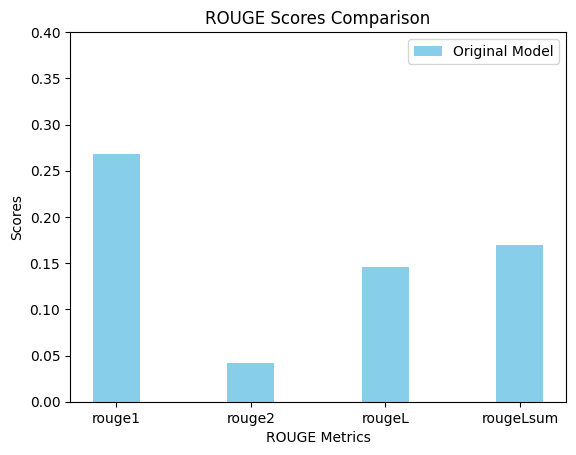

In [18]:
import matplotlib.pyplot as plt

original_model_results_scores = [x for _, x in original_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions
x = range(len(labels))

# Create bar graph
plt.bar(x, original_model_results_scores, width=bar_width,color ="#87CEEB", label='Original Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks(x, labels)

# Set y-axis limit to a maximum of 1
plt.ylim(0, 0.4)

plt.legend()

# Show the plot
plt.show()


# Model Training 

In [21]:
training_arguments = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    
)

In [22]:
import wandb

wandb.init(mode="disabled")

wandb: WARNING Disabling the wandb service is deprecated as of version 0.18.0 and will be removed in version 0.19.0.


In [23]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    max_seq_length=512,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [24]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
90,2.419100,2.528788
180,2.407600,2.486753
270,2.222900,2.457987
360,3.064500,2.427618
450,2.262400,2.417377


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=450, training_loss=2.543014898035261, metrics={'train_runtime': 1778.4752, 'train_samples_per_second': 0.506, 'train_steps_per_second': 0.253, 'total_flos': 9237647794028544.0, 'train_loss': 2.543014898035261, 'epoch': 1.0})

#  Evaluation

In [25]:
responses = []

for text_input, text_original_response in zip(dataset['test']['Patient'][:3], dataset['test']['Doctor'][:3]):
    # Create the message structure
    messages = [
        {
            "role": "user",
            "content": text_input
        }
    ]

    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512).to("cuda")

    # Generate the response with a limited number of new tokens
    outputs = model.generate(**inputs, max_new_tokens=150, num_return_sequences=1)

    # Decode the response
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(generated_text, text_original_response, "/n#####")

    # Extract the assistant's response
    response = generated_text.split("assistant")[1].strip()

    # Save both the original response and generated response
    responses.append({"original": text_original_response, "response": response})
    
#     break

user
I have a abscess in the gum on my lower right wisdom tooth. The dentist percribed me with both amoxicillin and metronidazole. I am taking them as stated and taking pail killers regularly, yet the pain is getting worse and my gum is getting more swollen and getting reder. My neck is also stiff and I get tingles running down my neck when I lie flat in bed also find it difficult to swallow when lying down. What should I do?
assistant
Hi,Thanks for your query. I have gone through your query in detail. I can understand your concern. I would like to tell you that you should continue the antibiotics as prescribed by your dentist. You should also take painkillers as prescribed by your dentist. You should also take warm saline gargles to reduce the swelling. You should also take soft diet. You should also avoid hot and spicy food. You should also avoid hard and chewy food. You should also avoid smoking. You should also avoid drinking alcohol. You should also avoid chewing tobacco. You shou

In [27]:
responses[2]['original']

'Hi, dear I have gone through your question. I can understand your concern. You have lump in lower lip.  It can be mucous retention cyst or benign cyst.  It can be dye to some obstruction in duct or other cause.  Surgical excision is the treatment of choice.  Consult your doctor and take treatment accordingly. Hope I have answered your question, if you have doubt then I will be happy to answer. Thanks for using health care magic. Wish you a very good health.'

In [28]:
responses[2]['response']

'Hi,Thanks for your query. The fluid that drained out is probably a cystic fluid. The cyst was probably infected and the fluid was a pus. The blood was probably from the needle prick. The cause of the cyst is not clear. It could be a sebaceous cyst or a salivary gland cyst. It could also be a lipoma. The best way to treat it is to get it excised. Hope I have answered your query. Let me know if I can assist you further. Regards, Dr. Sumanth MBBS, DCH, DNB (Paed), DNB (Surg), DNB (Paed. Surg). Paediatric Surgeon. Apollo Hospitals, Hyderabad. India. 91'

# Extracting Responses for Fine-Tuned Model and Baseline Comparison

In [29]:
fine_tuned_model_response = []
baseline_response = []

for response in responses:
    fine_tuned_model_response.append(response['response'])
    baseline_response.append(response['original'])

In [30]:
# Compute the ROUGE metrics
fine_tuned_model_results = rouge_metric.compute(
    predictions=fine_tuned_model_response,
    references=baseline_response[0:len(original_model_response)],
    use_aggregator=True,
    use_stemmer=True,
)

# Visualizing ROUGE Scores for the Fine-Tuned Model

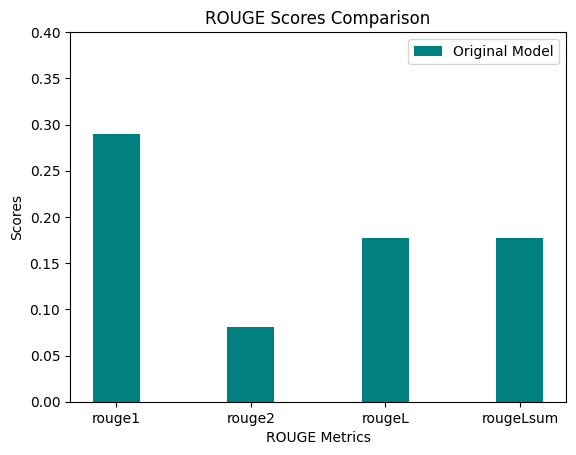

In [31]:
import matplotlib.pyplot as plt

fine_tuned_model_results_scores = [x for _, x in fine_tuned_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions
x = range(len(labels))

# Create bar graph
plt.bar(x, fine_tuned_model_results_scores, width=bar_width,color="teal", label='Original Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks(x, labels)

# Set y-axis limit to a maximum of 1
plt.ylim(0, 0.4)

plt.legend()

# Show the plot
plt.show()


# Comparing ROUGE Scores: Original Model vs. Fine-Tuned Model

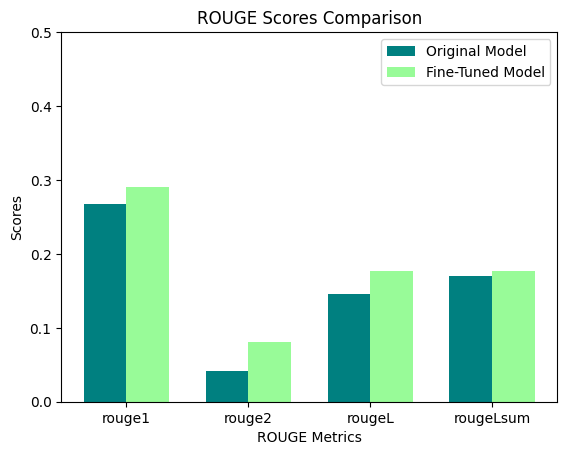

In [32]:
import matplotlib.pyplot as plt

# Original and fine-tuned model results
original_model_results_scores = [x for _, x in original_model_results.items()]
fine_tuned_model_results_scores = [x for _, x in fine_tuned_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions for original model bars
x = range(len(labels))

# X-axis positions for fine-tuned model bars
x_fine_tuned = [pos + bar_width for pos in x]

# Create bar graphs for both models
plt.bar(x, original_model_results_scores, width=bar_width,color="Teal", label='Original Model', align='center')
plt.bar(x_fine_tuned, fine_tuned_model_results_scores, width=bar_width,color="palegreen", label='Fine-Tuned Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks([pos + bar_width / 2 for pos in x], labels)
plt.ylim(0, 0.5)

# Add legend
plt.legend()

# Show the plot
plt.show()